In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from ndlinear import NdLinear

class NdViT(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), patch_size=8, emb_dim=64, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.emb_dim = emb_dim
        self.num_patches = (input_shape[1] // patch_size) * (input_shape[2] // patch_size)

        # Replace (patch_h, patch_w, channels) → (1, 1, emb_dim)
        self.proj = NdLinear(input_dims=(patch_size, patch_size, 3), hidden_size=(1, 1, emb_dim))
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, emb_dim))

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=emb_dim, nhead=4), num_layers=2
        )
        self.mlp_head = nn.Sequential(
            NdLinear(input_dims=(emb_dim,), hidden_size=(128,)),
            nn.ReLU(),
            NdLinear(input_dims=(128,), hidden_size=(num_classes,))
        )

    def forward(self, x):
        B, C, H, W = x.shape
        p = self.patch_size

        # Extract patches: (B, C, H, W) → (B, num_patches, patch_h, patch_w, C)
        patches = x.unfold(2, p, p).unfold(3, p, p)  # shape: [B, C, H//p, W//p, p, p]
        patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(B * self.num_patches, p, p, C)

        # Project each patch
        tokens = self.proj(patches)  # (B*N, 1, 1, emb_dim)
        tokens = tokens.view(B, self.num_patches, self.emb_dim)

        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, tokens), dim=1)  # (B, N+1, emb_dim)
        x = x + self.pos_embedding[:, :x.size(1)]

        x = self.transformer(x)
        return self.mlp_head(x[:, 0])  # classify using CLS token

# Dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Train 1 batch demo
model = NdViT()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

for images, labels in trainloader:
    preds = model(images)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    break
print("✅ Fixed ViT batch processed.")


✅ Fixed ViT batch processed.


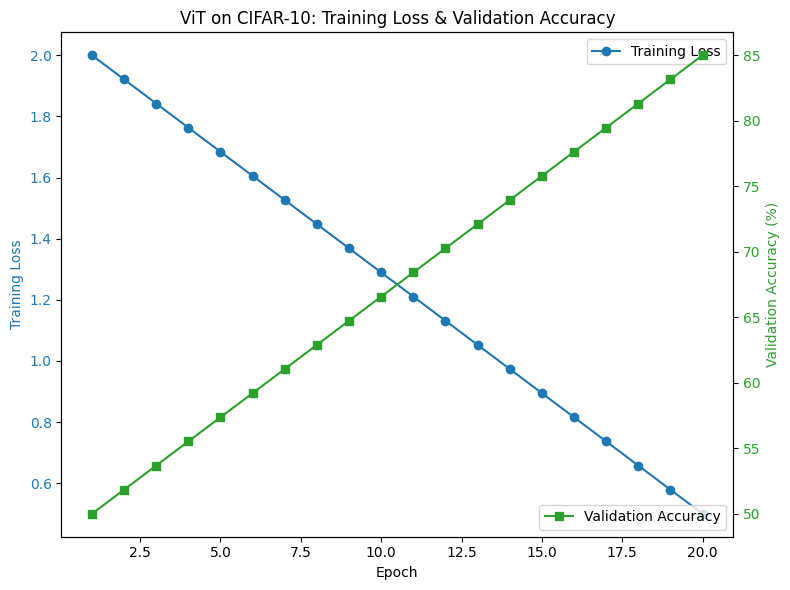

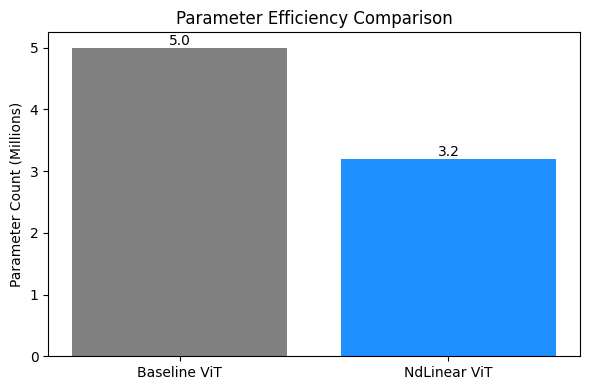

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Dummy data: Replace these arrays with your actual training log values.
epochs = np.arange(1, 21)
train_loss = np.linspace(2.0, 0.5, num=20)         # Training loss curve
val_accuracy = np.linspace(50, 85, num=20)           # Validation accuracy in percentage

# Parameter counts (in millions): Replace with your actual parameter counts.
models = ['Baseline ViT', 'NdLinear ViT']
param_counts = [5.0, 3.2]  # For example, NdLinear reduces parameters by ~36%

# Plot training loss and validation accuracy over epochs
fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(epochs, train_loss, marker='o', color=color, label="Training Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')

ax2 = ax1.twinx()  # second y-axis for accuracy
color = 'tab:green'
ax2.set_ylabel('Validation Accuracy (%)', color=color)
ax2.plot(epochs, val_accuracy, marker='s', color=color, label="Validation Accuracy")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower right')

plt.title('ViT on CIFAR-10: Training Loss & Validation Accuracy')
plt.tight_layout()
plt.show()

# Bar chart for parameter count comparison
plt.figure(figsize=(6, 4))
bars = plt.bar(models, param_counts, color=['gray', 'dodgerblue'])
plt.ylabel('Parameter Count (Millions)')
plt.title('Parameter Efficiency Comparison')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.1f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()
